# Dependências

In [ ]:
!pip install gensim

# Agrupamento de textos com K-Means

Neste notebook, usaremos o algoritmo k-means, um algoritmo simples e popular de agrupamento não-supervisionado, para agrupar letras de músicas de samba.

O objetivo do K-means é simples: agrupar pontos de dados semelhantes e descobrir padrões subjacentes. Para atingir esse objetivo, o K-means precisa de um número K de centróides em um conjunto de dados. Um centróide refere-se a um cluster, que é uma coleção de pontos de dados agregados devido a certas semelhanças entre si. As médias/means no K-means referem-se à média dos dados; isto é, encontrar o centróide. E o algoritmo é dito não supervisionado porque não temos conhecimento prévio sobre os grupos ou classes de nosso conjunto de dados, ou seja, encontraremos os grupos subjacentes em nosso conjunto de dados!

Abaixo podemos visualizar o algoritmo. Os centróides verdes correspondem aos pontos de dados mais próximos de cada um e formam clusters, então cada centróide se move para o centro de cada respectivo grupo e combina novamente os pontos de dados mais próximos entre si.

![alt text](https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Images/kmeans.gif?raw=true)

**Passos:**

__1.__ Explorar nossa coleção de músicas(corpus) <br>
__2.__ Aplicar engenharia de dados no conjunto de dados para obter o melhor desempenho do algoritmo K-means <br>
__3.__ Execute o algoritmo várias vezes, cada vez testando com um número diferente de clusters <br>
__4.__ Use diferentes métricas para visualizar nossos resultados e encontrar o melhor número de clusters (*ou seja, por que um total de X clusters é melhor do que um total de Y clusters?*) <br>
__5.__ Análise de cluster

**Métricas utilizadas para determinar o melhor número de K Cluters:**
- [Método do cotovelo](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

## Importando bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import altair as alt

In [ ]:
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

from wordcloud import WordCloud
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Algumas Funções úteis

In [ ]:
def counting_words(df, predict, column):
  labels = np.unique(predict)
  couting = []
  for i in labels:
    mask = df[column] == i
    next_to_cluster = df[mask]
    a = next_to_cluster['clean_lyrics'].str.split()
    freq_word = []
    for i in a:
      freq_word = freq_word + i
    couting.append(nltk.FreqDist(freq_word))

  return couting

In [ ]:
def generate_word_clouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroids[i]
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title(f'Cluster {i}')
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [ ]:
#Cálculo da PPMI
def compute_ppmi_smoothed(Xc, alpha=0.75):
    total = np.sum(Xc)
    sum_over_rows = np.sum(Xc, axis=1, keepdims=True)  # P(w)
    sum_over_cols = np.sum(Xc, axis=0, keepdims=True)  # P(c)

    # aplica suavização exponencial
    sum_over_rows_alpha = np.power(sum_over_rows, alpha)
    sum_over_cols_alpha = np.power(sum_over_cols, alpha)

    expected = sum_over_rows_alpha @ sum_over_cols_alpha / total
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi = np.log2((Xc * total) / expected)
        pmi[np.isinf(pmi)] = 0.0
        pmi[np.isnan(pmi)] = 0.0
        pmi = np.maximum(pmi, 0)  # PPMI
    return pmi

## Analisando os dados

In [ ]:
# Carregando um dataset de letras de músicas
letras = pd.read_csv('https://github.com/nazareno/palavras-nas-letras/raw/master/letras-ptbr-sample.csv')
#Subamostrando devido restrições de memória do colab
letras = letras.sample(1000, random_state=42)
letras.sample(10)

,SName,Lyric,Artist,Songs,Popularity,Genre,Genres
4396,É Problema Meu,E se eu bebo é problema meu. Se eu vivo na noi...,Tchê Garotos,147,1.0,Sertanejo,Sertanejo; Regional; Romântico; Trilha Sonora;...
2642,Eu Dou Risada,Eu espero que você não morra de amores. Enquan...,Manu Gavassi,60,2.0,Pop,Pop/Rock; Pop; Romântico; Funk; Dance; Rock; S...
693,Saco De Ouro,Num saco de estopa. Com embira amarrado. Eu te...,Chico Rey e Paraná,232,2.2,Sertanejo,Sertanejo; Romântico; Country; Disco; Jovem Gu...
1672,Tô Vendo Que Você Tá Bem,Tô vendo que você tá bem. Tô vendo que arranjo...,Henrique e Diego,98,3.3,Sertanejo,Sertanejo; Romântico; Trilha Sonora; Funk Cari...
4263,Como Nós Somos Unidos,Sandy eu tive uma idéia que você vai adorar. U...,Sandy & Junior,201,14.0,Pop,Pop
2550,Navegadora (para Scarlet),rosa dos ventos lunares. bússula superior. pól...,Lulu Santos,271,10.0,Rock,Pop/Rock; Rock; Pop; MPB; Dance; Electronica; ...
2658,CB (Sangue Bom),(como diz o meu parceiro bezerra da silva. Eu ...,Marcelo D2,115,4.6,Samba,Hip Hop; Rap; Samba; Rock; Black Music; Reggae...
2268,Chicletinho,Xararari .. Xarariron. Xararari .. Xarariron. ...,Latino,126,2.1,Pop,Dance; Pop; Romântico; Hip Hop; Funk Carioca; ...
4432,Amargo Prazer,Meu bem por mais que você queira. Fingir que e...,Teodoro e Sampaio,443,2.8,Sertanejo,Sertanejo; Forró; Country; Regional; Axé; Clás...
4246,Meu Disfarce (Part. Xororó),Você vê esse meu jeito. De pessoa liberada. Ma...,Sandy,88,9.3,Pop,Romântico; Pop; MPB; Pop/Rock; Trilha Sonora; ...


In [ ]:
#Informações das colunas do nosso dataframe
print(letras.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4656 to 1128
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SName       1000 non-null   object 
 1   Lyric       1000 non-null   object 
 2   Artist      1000 non-null   object 
 3   Songs       1000 non-null   int64  
 4   Popularity  1000 non-null   float64
 5   Genre       1000 non-null   object 
 6   Genres      1000 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 62.5+ KB
None


In [ ]:
#Artistas mais presentes nesse sample
letras['Artist'].value_counts()[0:20]

,count
Artist,
Gian & Giovani,10
Paulo Ricardo,10
Kleiton e Kledir,8
Hungria,8
Gabriel O Pensador,8
Ultraje A Rigor,8
RPM,8
Claudinho & Buchecha,8
Projota,7


## Pré processamento do texto

In [ ]:
sw = stopwords.words('portuguese')
personalizadas = ['pra', 'mim', 'vou', 'vai', 'vem', 'tão','tudo','quer']
sw = sw + personalizadas
clean_lyrics = []

for lyric in letras['Lyric']:
    # Remove caracteres especiais e dígitos
    lyric = re.sub(r"(\d|\W|_)+|\w*\d\w*", " ", lyric)

    # Divide em palavras
    words = lyric.lower().split()

    # Remove stopwords e palavras curtas ou com números
    words = [w for w in words if w not in sw and len(w) > 2 and not any(c.isdigit() for c in w)]

    # Junta de volta
    cleaned = ' '.join(words)
    clean_lyrics.append(cleaned)

clean_lyrics[:10]

['louco hein filha quanta energia pede todo dia toda forma academia queria judia deve vício terapia relaxar terminar mente vez vez faz dez minutos gente parou calor quanto amor pede ver feliz além parar passar madrugada querendo hora hora preparar porque brincar pouquinho continua pouquinho continua hora parar louco hein filha quanta energia pede todo dia toda forma academia queria judia deve vício terapia relaxar terminar mente vez',
 'sei muitos hoje dia vivem vidas fio olhos fecham continuam acordados escuridão noite parece ter fim vida passageiro sorriso festim sei vida fácil dias sinto assim fortalece prosseguir irmão clame vida dentro pois clamar joelhos prostrar consolo chegará nova vida viverá medo cessará pois cristo irá reinar habita irá sentir sei muitos hoje dia vivem vidas fio olhos fecham continuam acordados escuridão noite parece ter fim vida passageiro sorriso festim sei vida fácil dias sinto assim irmão clame vida dentro pois clamar joelhos prostrar consolo chegará nov

In [ ]:
#Adicionando as letras preprocessadas no dataframe original
letras['clean_lyrics'] = clean_lyrics

#Liberando memória
del clean_lyrics

In [ ]:
letras

,SName,Lyric,Artist,Songs,Popularity,Genre,Genres,clean_lyrics
4656,Tá Louco Hein,"Ta louco, hein filha!. Quanta energia, pede to...",Turma do Pagode,182,11.7,Samba,Romântico; Pagode; Samba; Sertanejo; Funk Cari...,louco hein filha quanta energia pede todo dia ...
3659,Nova Vida,Eu sei que muitos hoje em dia. Vivem suas vida...,PG,111,1.1,Rock,Rock; Gospel/Religioso; Pop/Rock; Funk; Clássi...,sei muitos hoje dia vivem vidas fio olhos fech...
907,Quem Sou Eu,Certas coisas sei que nunca vão mudar. Se eu t...,CPM 22,114,3.2,Rock,Hardcore; Punk Rock; Rock; Pop/Rock; Hard Rock...,certas coisas sei nunca vão mudar todas respos...
4352,Puro Diamante,Com ela é que não pago pra sonhar. Não vivo de...,Strike,49,1.3,Rock,Pop/Punk; Rock; Pop/Rock; Rock Alternativo; Pu...,pago sonhar vivo ilusão existe raro milhão tem...
3271,Fulminante,Eu amei. Nem sempre se calcula o risco mesmo a...,Mumuzinho,71,4.3,Samba,Pagode; Romântico; Samba; MPB; Sertanejo; Gosp...,amei sempre calcula risco assim amei desperdic...
...,...,...,...,...,...,...,...,...
3588,Só Me Fez Bem,Não sei se foi um mal/ não sei se foi um bem/....,Paulo Ricardo,143,2.2,Pop,Pop; Romântico; Pop/Rock; Rock; MPB; Trilha So...,sei mal sei bem sei fez bem coração sofri sofr...
679,Minha Embaixada Chegou,Minha embaixada chegou. Deixa meu povo passar....,Chico Buarque,447,14.1,Samba,Bossa Nova; Samba; MPB; Romântico; Samba Enred...,embaixada chegou deixa povo passar povo pede l...
3998,Natalício,Brilha em cima do rancho. Uma estrela a luz e ...,Renato Teixeira,203,1.1,Sertanejo,Regional; Sertanejo; MPB; Folk; Axé,brilha cima rancho estrela luz dia todo menino...
2706,Passarinho Fofoqueiro,Se um passarinho fofoqueiro aparecer aí. Dizen...,Marcos e Belutti,143,5.6,Sertanejo,Sertanejo; Romântico; Trilha Sonora; Country; ...,passarinho fofoqueiro aparecer dizendo uns abs...


## Vetores TF-IDF
Nesta etapa, as músicas são vetorizadas aplicando TFIDF. Ainda não está sendo empregado a estratégia de buscar os embeddings das palavras e transformar as sentenças em um vetor com base nos vetores de suas palavras.

In [ ]:
tfv = TfidfVectorizer(
        min_df = 10,
        max_df = 0.5,
        max_features = None,
        stop_words = sw
  )

vec_text = tfv.fit_transform(letras['clean_lyrics'])

words = tfv.get_feature_names_out()

len(words)

1127

In [ ]:
words[1:10]

array(['abraçar', 'abraço', 'abre', 'abrigo', 'abrir', 'acaba', 'acabar',
       'acabou', 'aceita'], dtype=object)

## Agrupando com o K-Means

Para simplificar o trabalho, vamos escolher **4 grupos**. Ou seja, vamos tentar identificar quais músicas são mais parecidas entre si, considerando apenas 4 grupos distintos.

PS: existem métodos específicos para tentar definir um melhor k com base nos próprios dados.

In [ ]:
k = 4

In [ ]:
#Nesta etapa, um objeto da classe kmeans é instanciado e executamos o algoritmo considerando cada música vetorizada por tfidf
kmeans = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
kmeans.fit(vec_text)
labels_tfidf = kmeans.predict(vec_text)

#Criando um novo dataframe
letras['tfidf_group'] = labels_tfidf

letras.sample(10)

,SName,Lyric,Artist,Songs,Popularity,Genre,Genres,clean_lyrics,tfidf_group
1392,Beijo Na Boca É Coisa do Passado,Beijo Na boca é coisa do Passado. Beijo na boc...,Furacão 2000,57,2.8,Hip Hop,Funk Carioca; Axé; Hip Hop; Rap; Dance; Funk; ...,beijo boca coisa passado beijo boca coisa pass...,2
3814,Quando Acabou,Quando acabou nosso romance o meu mundo desabo...,Raça Negra,280,14.3,Samba,Romântico; Samba; Pagode; Axé; MPB; Regional; ...,acabou romance mundo desabou solidão abrigou s...,2
100,Brilho no Olhar,Tom............: D. Introdução.: D7+ Em7 F#m7 ...,Almir Guineto,66,1.2,Samba,Samba; Pagode; Velha Guarda; Axé; Dance; MPB,tom introdução solo aconteceu sentimento cadê ...,2
2177,Corta Essa,"Trim, Trim. _Oi!. _Demorou pra atender,hem, fa...",Kelly Key,84,1.8,Pop,Dance; Pop; Romântico; Infantil; Pop/Rock; Fun...,trim trim demorou atender hem fala sério pare ...,2
765,Ai Quem Me Dera,Ai quem me dera terminasse a espera. Retornass...,Clara Nunes,201,3.6,Samba,Samba; MPB; Velha Guarda; Samba Enredo; Românt...,dera terminasse espera retornasse canto simple...,0
1961,Quando o Amor Acontece,"Coração sem perdão, diga fale por mim. Quem ro...",João Bosco,146,1.4,Samba,MPB; Samba; Romântico; Bossa Nova; Clássico; S...,coração perdão diga fale roubou toda alegria a...,1
2727,É Fogo (Aquela do Zezé),Não é que a ligação caiu. Ela que desligou na ...,Maria Cecilia e Rodolfo,132,2.1,Sertanejo,Sertanejo; Romântico; Country; Funk Carioca; F...,ligação caiu desligou cara outro cara casa des...,2
530,Blecaute,Hoje houve uma. mudança na cidade. Hoje houve ...,Capital Inicial,196,8.1,Rock,Pop/Rock; Rock; Rock Alternativo; Punk Rock; M...,hoje mudança cidade hoje mudança cidade ningué...,0
1945,"Dois Pra lá, Dois pra cá",Sentindo frio em minh'alma te convidei pra dan...,João Bosco,146,1.4,Samba,MPB; Samba; Romântico; Bossa Nova; Clássico; S...,sentindo frio minh alma convidei dançar voz ac...,1
2890,Desejo,Sinto desejo por você. Meu corpo anseia pelo s...,Matogrosso e Mathias,275,4.0,Sertanejo,Sertanejo,sinto desejo corpo anseia sonhos querem sonhar...,1


In [ ]:
#Verificando a quantidade de letras atribuídas a cada grupo
letras['tfidf_group'].value_counts()

,count
tfidf_group,
2,461
1,362
0,133
3,44


In [ ]:
#Listando os cantores presentes em cada grupo e a quantidade de músicas dele que faz parte do grupo
for g in range(0, k):
  print('\n-----\nGRUPO {}:'.format(g))
  print(letras.query('tfidf_group ==  {}'.format(g))['Artist'].value_counts()[0:10])
  print('-----')


-----
GRUPO 0:
Artist
Hungria                     4
Pedra Letícia               3
Marcelo D2                  3
Racionais Mc's              3
Ao Cubo                     3
Tião Carreiro e Pardinho    3
Frejat                      3
Karol Conka                 3
Titãs                       3
Velhas Virgens              3
Name: count, dtype: int64
-----

-----
GRUPO 1:
Artist
Gian & Giovani         7
Di Paullo e Paulino    6
Edson e Hudson         6
Kleiton e Kledir       5
Alexandre Pires        5
Paulo Ricardo          5
Diogo Nogueira         4
RPM                    4
Teodoro e Sampaio      4
Tonico e Tinoco        4
Name: count, dtype: int64
-----

-----
GRUPO 2:
Artist
Gabriel O Pensador      7
Kelly Key               6
Ultraje A Rigor         6
Barão Vermelho          6
Cazuza                  5
Projota                 5
Arlindo Cruz            5
Claudinho & Buchecha    5
Marcos e Belutti        5
Anitta                  5
Name: count, dtype: int64
-----

-----
GRUPO 3:
Artist
PG

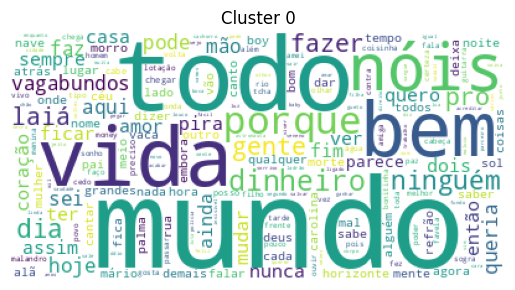

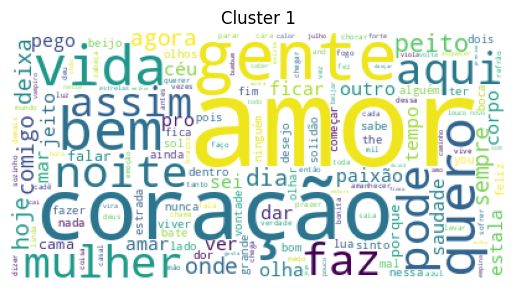

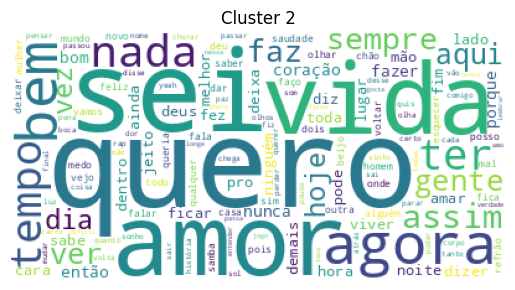

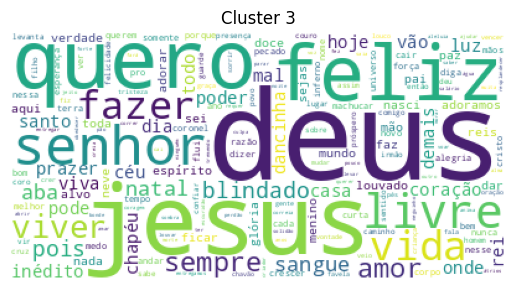

In [ ]:
# Exibindo as palavras mais comuns e cada grupo
generate_word_clouds(counting_words(letras,labels_tfidf, 'tfidf_group'))

In [ ]:
#Exibindo alguns regristo de um certo grupo
#Escolha um grupo e analise os artistas, letras e gêneros

pd.options.display.max_colwidth = 100
letras.query('tfidf_group == 2')[['SName', 'Lyric', 'Artist', 'Genre']].sample(10)

,SName,Lyric,Artist,Genre
240,Boca Sem Dente,Aquela boca sem dente que eu beijava. Já está de dentadura. Aquela roupa velha que você usava. H...,Arlindo Cruz,Samba
3739,Love Song,"Fui atraído daqueles tipo amor bandido. Devido ao encanto que você trouxe pra mim, enfim. Você c...",Pollo,Hip Hop
4245,Quando Eu Era Vivo,Quando nasci era de quem a voz. Que sussurrou vai ser mais um de nós. Não um que treme com o fri...,Sandy,Pop
51,Ela Disse-Me Assim (Vá Embora),"Ela disse-me assim. ""Tenha pena de mim. Vá embora!. Ele pode chegar. Vais me prejudicar. Tá na h...",Adriana Calcanhotto,Pop
1924,Ela É,"""Eu vou misturar. Funk-Soul com Samba aahhh. Eu vou misturar funk e soul. É Samba Funk-Soul brot...",Jeito Moleque,Samba
3692,O Inimigo,Eu sou o inimigo. Eu sou o paradoxo. O crime e o castigo. O universo e seu umbigo. Unânime e con...,Pitty,Rock
192,"Blá, Blá, Blá (Extended Remix)","Vou rebolar só porque você não gosta. Se não quiser me olhar, vira de costas. Você vai ter que a...",Anitta,Pop
1173,O Preço,"O preço que se paga as vezes é alto demais. É alta madrugada, já é tarde demais. Pra pedir perdã...",Engenheiros do Hawaii,Rock
2276,Novo,Só bastou seu olhar magnético. Sem respiro nenhum você me deixou. Quando o ritmo da música começ...,Laura Pausini,Pop
2788,De Quem É a Culpa?,Exagerado sim. Sou mais você que eu. Sobrevivo de olhares. E alguns abraços que me deu. E o que ...,Marília Mendonça,Sertanejo


## PPMI (Positive Pontual Multiwise Individual)

Agora vamos trabalhar com um método diferente de vetorização. Vamos calcular o PPMI de cada palavra e depois transformar as letras utilizando os embeddings de cada palavra em cada letra.


1. Utilize um vetorizador para contar cada palavra (bag-of-words) da coluna clean_lyrics do dataframe. Salve o resultado da vetorização na variável X

In [28]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(letras['clean_lyrics'])

In [22]:
#Essa etapa está pronta, não é necessário mudá-la. Aqui estamos gerando a matriz de co-ocorrência das palavras
Xc = (X.T @ X).toarray()  # coocorrência entre palavras

2. Invoque a função compute_ppmi_smoothed para calcular o PPMi de cada palavra. Você pode fazer isso passando a variável Xc como argumento do método. Salve o resultado na variável ppmi_matrix

In [23]:
ppmi_matrix = compute_ppmi_smoothed(Xc)

3. Crie um dataframe chamado ppmi_df. Para essa criação você precisa da variável ppmi_matrix e do nome de cada coluna. Os nomes podem ser obtidos utilizando o vetorizador criado anteriormente e invocando o método get_features_names_out(). A criação pode ser feita utilizando o método pd.Dataframe(seu_dados, index=suas_palavras, columns=suas_palavras)

In [29]:
ppmi_df = pd.DataFrame(ppmi_matrix, index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())

ppmi_df.head()

,aaa,aaaaaaaaa,aaaaaaah,aaaaah,aaaah,aaahhh,aah,aahh,aahhh,aai,...,ôuôuôu,ôuôô,ôôh,última,últimas,último,única,único,útero,útil
aaa,37.895701,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaaaaaaa,0.000000,37.582707,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaaaaah,0.000000,0.000000,40.302654,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaaah,0.000000,0.000000,0.000000,36.487561,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaah,0.000000,0.000000,0.000000,0.000000,38.018257,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#Esse trecho não precisa ser alterado. Estamos apenas liberando espaço na memória
del ppmi_matrix

4. Complete o método abaixo para que ele seja capaz de transformar cada letra das músicas em sua forma vetorizada utilizando os embeddigns das palavras do dataframe ppmi_df.

In [32]:
#Esse método está parcialmente implementado
def lyric_embeddings_from_ppmi(df, text_column, ppmi_df):

    #Essa variável irá salvar os embeddings de cada letra
    embeddings = []
    words_in_vocab = set(ppmi_df.index)

    for lyric in df[text_column]:

        #1. Para cada letra do dataframe, primeiro separe as palavras pelo espaço

        #2. Para cada palavra que foi separada por espaço, busque no dataframe ppmi_df seu embedding e salve-a em um vetor auxiliar
        # Você pode fazer buscar um embedding de uma palavra usando o método .loc[sua_palavra].values do dataframe ppmi_df
        # Lembre que, para cada embedding, você precisa adicioná-lo ao vetor temporário.


        #3. Calcule a média de todos os embeddings salvos no vetor temporário da etapa anterior
        # Você pode fazer isso utilizado a o método np.mean(seu_vetor_de_vetores, axis=0) e salvando o resultado na variável lyric_vector


        #4. Salvando o embedding de cada letra, ou seja, a versão vetorizada da letra.
        embeddings.append(lyric_vector)

    # Criando um novo DataFrame com as representações e retornando-a
    embedding_df = pd.DataFrame(embeddings, index=df.index)
    return embedding_df

In [33]:
# Essa etapa já está pronta, não é necessário mudá-la. Aqui, passamos nosso dataframe de letras e recebemos um dataframe de embeddings
ppmi_embeddings_df = lyric_embeddings_from_ppmi(letras, 'clean_lyrics', ppmi_df)
ppmi_embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13877,13878,13879,13880,13881,13882,13883,13884,13885,13886
4656,0.452781,3.257085,0.475157,2.851651,0.960642,1.401907,2.299785,3.217977,1.384425,1.893404,...,1.391469,0.000000,3.656747,7.799429,4.386843,14.258663,7.843355,8.375606,4.165369,1.879596
3659,0.934641,4.630377,0.000000,4.374975,6.079066,0.459598,6.223985,3.705612,0.453813,2.343149,...,3.748646,4.843069,3.743335,6.531157,1.414559,13.931903,10.207898,10.352688,6.853850,3.069616
907,3.115173,2.183810,0.437123,7.184558,1.708888,3.049400,4.538074,2.992697,3.011918,0.432090,...,4.745290,2.633587,5.234896,7.045057,1.793736,17.593722,9.870169,10.311996,3.366608,3.744600
4352,3.846360,3.318663,0.557709,4.321832,1.523346,2.063888,3.196558,4.174552,2.038838,1.304748,...,4.589735,3.727057,4.105043,8.675774,1.652152,11.755298,10.052854,10.657001,2.125932,2.789998
3271,4.601457,3.295137,0.000000,3.209918,0.822833,0.560476,1.792380,0.805247,0.553702,0.000000,...,5.746624,1.904883,2.474212,10.777007,5.551255,12.758053,8.475881,11.727298,1.088031,2.783798


5. Agora, vamos executar o Kmeans como nosso dataframe ppmi_embeddings_df. Você pode ver o exemplo de uso do KMeans na Seção Inicial deste notebook.

- Use k = 4
- Crie um novo objeto do tipo MiniBatchKMeans
- Salve as classificações na variável labels_pmi
- Faça uma nova coluna no dataframe letras (letras['pmi_group']) e atribua labels_pmi

In [35]:
k = 4
MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
kmeans.fit(ppmi_embeddings_df)
labels_pmi = kmeans.predict(ppmi_embeddings_df)

letras['pmi_group'] = labels_pmi

letras.sample(10)

,SName,Lyric,Artist,Songs,Popularity,Genre,Genres,clean_lyrics,tfidf_group,pmi_group
2495,Vem Me Saciar,"2X Eu tenho fome, eu tenho sede. Estou sedento de te encontrar. Tua presença, é meu alento. me a...",Ludmila Ferber,229,4.3,Sertanejo,Gospel/Religioso; Country; Sertanejo; Clássico; Romântico; Infantil; MPB; Axé; Reggae; Classic R...,fome sede sedento encontrar presença alento alimento adorar saciar jesus presença palavra unção ...,3,1
2813,As Mariposas,As mariposa quando chega o frio. Fica dando vorta em vorta da lâmpida pra si isquentá. Elas roda...,Mart'nália,87,1.0,Samba,Samba; MPB; Bossa Nova; Jazz; Kizomba; Black Music; Axé,mariposa chega frio fica dando vorta vorta lâmpida isquentá roda roda roda dispois senta cima pr...,1,3
95,Milla / Eva,"Ô Milla!. Mil e uma noites. De amor com você. Na praia, num barco. Num farol apagado. Num moinho...",Alexandre Pires,195,6.2,Samba,Samba; Romântico; Pagode; Axé; Dance; Sertanejo; Funk Carioca; Funk; Trilha Sonora; Electronica;...,milla mil noites amor praia barco farol apagado moinho abandonado mar grande alto astral hollywo...,1,1
3014,Vem Pra Cá,"Vem pra cá, vem. Vem pra cá, vem, vem. Vem pra cá, vem. Vem pra cá, vem, vem. Vem pra cá, sou se...",Mc Gui,27,1.1,Pop,Funk Carioca; Funk; Pop; Axé; Electronica; Black Music; Forró; Sertanejo; House; Blues; Clássico...,chamego fazer feliz jeito beija coisas diz brincadeiras baixo edredom frutas bom licor caixa bom...,2,1
4553,Senhor,Senhor!. Não me livre do pecado. Me livre da culpa. Senhor!. Não me livre do perigo. Me livre da...,Titãs,228,8.9,Rock,Pop/Rock; Rock; Hard Rock; MPB; Pop; World Music; Punk Rock; Heavy Metal; Pós-Punk; Rock Alterna...,senhor livre pecado livre culpa senhor livre perigo livre multa senhor livre inferno livre tédio...,3,1
3982,Não Ditas Por Mim,"Não Ditas por Mim. /ABORTO ELÉTRICO, RENATO RUSSO/. Tratado por pessoa. Ou ouvindo sua voz. E po...",Renato Russo,61,6.2,Rock,Rock; MPB; Pop/Rock; Romântico; Clássico; Trilha Sonora; Pós-Punk; Punk Rock; Classic Rock; Funk...,ditas aborto elétrico renato russo tratado pessoa ouvindo voz podendo tocar sempre lado pensamen...,2,1
3650,Meu Universo,Que sejas meu universo. Não quero dar-te só um pouco do meu tempo. Não quero dar-te um dia apena...,PG,111,1.1,Rock,Rock; Gospel/Religioso; Pop/Rock; Funk; Clássico; Punk Rock,sejas universo quero dar pouco tempo quero dar dia apenas semana sejas universo quero dar palavr...,3,1
4173,Genêse,"Perto do fim do mundo. Todo final, no fundo,. Parece recomeçar. Parece retomar, parece refazer. ...",RPM,64,1.9,Rock,Rock; Pop/Rock; Rock Alternativo; Pop; Hard Rock; MPB; Infantil; Gospel/Religioso; Soul Music; C...,perto fim mundo todo final fundo parece recomeçar parece retomar parece refazer parece prece pra...,0,0
179,Se Tudo Acaba,Quero ter você. Por perto. Desperto ao teu amor. Quero prometer verdade. Me guarde. Em você. Sem...,Anavitória,43,23.8,Pop,Indie; Pop; Folk; MPB; Romântico; Sertanejo; Blues; Country; Chillout; House; New Wave; Kizomba;...,quero ter perto desperto amor quero prometer verdade guarde ter pressa chega logo ver tanto pouc...,2,2
4620,Academia Kamika-Z,"É Academia isso aqui irmão. Kamika-z... Hã. É Kamika-z fii. Viaja não... É. Chuy, Narguilé, cris...",Tribo da Periferia,112,10.8,Hip Hop,Hip Hop; Rap; Funk; Black Music; Axé; Reggae; Funk Carioca; Trip-Hop; Blues; Romântico; Pop/Rock...,academia aqui irmão kamika kamika fii viaja chuy narguilé cristalina pause soulja minutos bater ...,2,1


6. A partir daqui, não é necessário nenhuma implementação. Apenas execute as células para realizar análises sobre os resultados.

In [36]:
#Verificando a quantidade de letras por grupo.
letras['pmi_group'].value_counts()

,count
pmi_group,
1,475
2,295
3,220
0,10


In [37]:
#Listando os cantores presentes em cada grupo e a quantidade de músicas dele que faz parte do grupo
for g in range(0, k):
  print('\n-----\nGRUPO {}:'.format(g))
  print(letras.query('pmi_group ==  {}'.format(g))['Artist'].value_counts()[0:10])
  print('-----')


-----
GRUPO 0:
Artist
Titãs                    2
RPM                      1
Legião Urbana            1
Engenheiros do Hawaii    1
Samprazer                1
Grupo Tradição           1
Frejat                   1
Ventania                 1
Paulo Ricardo            1
Name: count, dtype: int64
-----

-----
GRUPO 1:
Artist
PG                       5
Barão Vermelho           5
Hungria                  5
Projota                  5
Cezar & Paulinho         5
Zé Henrique e Gabriel    4
Guilherme e Santiago     4
Mc Pocahontas            4
Gino & Geno              4
Xuxa                     4
Name: count, dtype: int64
-----

-----
GRUPO 2:
Artist
Paulo Ricardo        7
Raça Negra           7
Gian & Giovani       6
Só Pra Contrariar    5
Alcione              4
Bruninho e Davi      4
Rick & Renner        4
Rodriguinho          4
Anitta               4
Ludmilla             4
Name: count, dtype: int64
-----

-----
GRUPO 3:
Artist
Mc Neguinho do Kaxeta    5
Adoniran Barbosa         5
Mag            

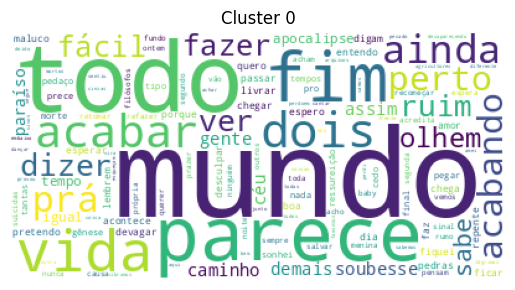

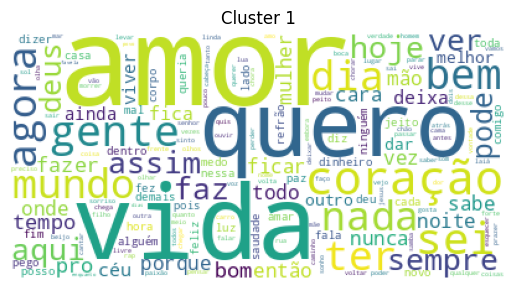

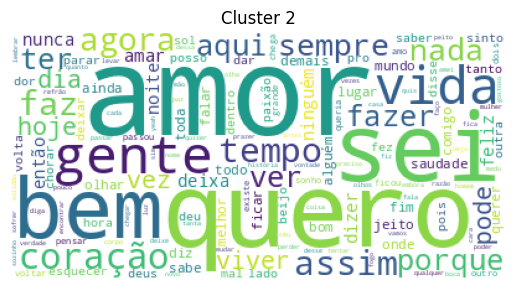

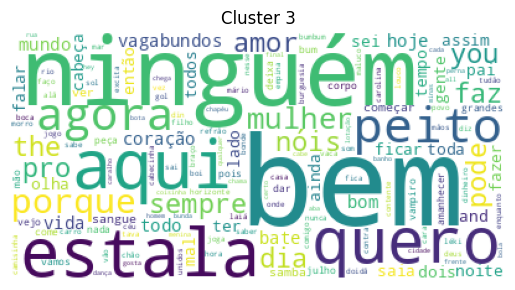

In [38]:
generate_word_clouds(counting_words(letras,labels_pmi, 'pmi_group'))

In [39]:
#Exibindo alguns regristo de um certo grupo
#Escolha um grupo e analise os artistas, letras e gêneros

pd.options.display.max_colwidth = 100
letras.query('pmi_group == 3')[['SName', 'Lyric', 'Artist', 'Genre']].sample(10)

,SName,Lyric,Artist,Genre
4230,Olhos Meus,"Olhos meus. Olhem em volta. Me vejam, me mostrem. Olhos meus. Abram-se ao belo. Percebam o brilh...",Sandy,Pop
2916,Boomzim,"Me manda uma tradicional. Eu tô com um beck bem legal. Dona, a tua boca eu quero pra ser fio den...",Matuê,Hip Hop
3499,Uma Brasileira,"Rodas em sol, trovas em do. Uma brasileira, o. Uma forma inteira, o. You, you, you. Nada de mais...",Os Paralamas do Sucesso,Rock
4664,A Festa,Eu esperei o mês inteiro o dia da festa chegar. Ensaiava no banheiro muxôxos só prá te agradar. ...,Ultraje A Rigor,Rock
151,Amanhecer Em Julho,Amanhecer Em Julho amanhecer em julho. Amanhecer Em Julho amanhecer em julho. Amanhecer Em Julho...,Ana Carolina,Pop
3692,O Inimigo,Eu sou o inimigo. Eu sou o paradoxo. O crime e o castigo. O universo e seu umbigo. Unânime e con...,Pitty,Rock
4291,La La La (Brasil 2014) (Part. Carlinhos Brown),"Essa bola vai rolar. Mundo é um tapete verde. Quando a bola chega lá. O coração fica na rede, na...",Shakira,Pop
1808,Vinte E Nove,Perdi vinte em vinte e nove amizades. Por conta de uma pedra em minhas mãos. Embriaguei morrendo...,Isabella Taviani,Rock
3007,Se Joga no Fervo (Com Mc Nego Blue),Se joga no fervo!. Se joga no. Elas vai e vem. Se joga no vai e vem. Se joga no vai e vem. Se Jo...,Mc Gui,Pop
2617,Não Peide Aqui Baby,Não peide aqui baby (não peide aqui baby). não é legal! (não é legal). olha só o cheiro disso mu...,Mamonas Assassinas,Rock


## Perguntas sobre o PMI

Responda cada perguntando apresentando uma justificativa

1. Considerando os artistas de cada grupo, é possível verificar alguma conexão entre eles? (Ex: gênero, estilo de música, temas abordados)

A única conexão é pelas palavras em cada música, como"amor", "coração", "paixão" que são muito utilizadas mas em questão de gênero não tem conexão.

2. Considerando as nuvens de palavras de cada grupo, argumente se existe um grupo bem definido ou se não existe uma definição clara sobre que tipo de música (tema) cada grupo tem.

Com o PPMI, os grupos de palavras geralmente têm uma definição é mais clara porque algumas pralavras aparecem frequentemente juntas, por exemplo, "festa", "dança", "curtição" em um grupo; "saudade", "voltar", "esquecer" em outro. Isso faz com que cada grupo tenha um tema bem definido e fácil de interpretar.

3. De maneira geral, você acha que os resultados do PPMI são mais consistentes que os do TFIDF?

Sim, os resultados do PPMI são mais consistentes e úteis para entender temas. O TF-IDF se concentra em palavras que são raras, o que nem sempre cria grupos temáticos lógicos. O PPMI foca em palavras que estão estatisticamente associadas, palavras que "andam juntas" nas frases, fazendo que tenham um mesmo "tema".

# Word2Vec

Agora vamos trabalhar com o Word2Vec. Primeiramente vamos treinar os embeddings considerando todas as letras do nosso dataset. Em seguida, vamos vetorizar essas letras utilizando os embeddings das palavras de cada letra. Em seguida, vamos aplicar o KMeans e analisar os grupos.

1. Inicialmente, precisamos quebrar cada letra do nosso dataset em uma lista de palavras. Isso deve ser feito para cada letra. O resultado deve ser um vetor de vetores, em que cada subvetor é o conjunto de palavras da letra atual. Lembre-se que você deve considerar as letras que estão na coluna 'clean_lyric' do dataframe.

In [42]:

tokenized_lyrics = [lyric.split() for lyric in letras['clean_lyrics']]

2. Chame a classe Word2Vec() passando para ela o vetor de letras que estão separadas por espaço. Além disso, utilize os seguintes parâmetros:

- vector_size=100,  # tamanho dos vetores
- window=5,
- min_count=2,
- workers=4,
- epochs=15,
- sg=1


- Salve o modelo na variável w2v_model

In [41]:
w2v_model = Word2Vec(sentences=tokenized_lyrics, vector_size=100, window=5, min_count=2, workers=4, epochs=15, sg=1)

w2v_model.wv['amor']

array([ 1.92955270e-01,  5.24799764e-01,  3.72489356e-02, -2.59573455e-04,
       -5.16876996e-01, -3.67993861e-01,  9.85909179e-02,  2.15778500e-01,
       -1.60712585e-01, -1.72664911e-01,  4.36092675e-01, -3.44989508e-01,
       -4.29503024e-01,  3.35616380e-01, -1.88752547e-01, -2.20182970e-01,
        7.28492856e-01,  2.84939408e-01, -5.41899621e-01, -8.93937171e-01,
        4.01918173e-01,  2.90863276e-01,  2.89693862e-01, -5.23656368e-01,
        1.40614500e-02,  1.03246264e-01, -4.63599473e-01,  1.20701261e-01,
       -4.72929537e-01, -3.09674829e-01, -1.36184961e-01,  7.27772862e-02,
        1.39333576e-01, -3.01589251e-01, -1.75447628e-01,  1.49019524e-01,
       -1.94783062e-01, -5.47378182e-01, -5.80039881e-02, -1.95500597e-01,
       -6.37956142e-01, -4.58822995e-02, -1.06706120e-01,  3.26173492e-02,
        1.90156773e-01,  1.43930659e-01, -2.93418229e-01, -1.96338266e-01,
        6.80542439e-02,  5.76954901e-01,  1.66649908e-01,  1.76643699e-01,
       -4.18104202e-01,  

3. Complete o método abaixo para que ele seja capaz de transformar cada letra das músicas em sua forma vetorizada utilizando os embeddigns das palavras que você pode obter do modelo w2v_model.

In [50]:
#Este método está parcialmente completo. Ele tem algumas similaridades com o método de
def lyric_embeddings_from_w2v(df, text_column, w2v_model):

    #Aqui será armazenando o embedding final de cada letra.
    embeddings = []
    vocab = w2v_model.wv.key_to_index

    for lyric in df[text_column]:

        #1. Para cada letra do dataframe, primeiro separe as palavras pelo espaço
        words = lyric.split()


        #2. Para cada palavra que foi separada por espaço, busque no w2v_model seu embedding e salve-a em um vetor auxiliar
        # Você pode fazer buscar um embedding de uma palavra usando o método w2v_model.wv[sua_palavra]
        # Lembre que, para cada embedding, você precisa adicioná-lo ao vetor temporário.
        word_vectors = []
        for word in words:
            if word in vocab:
                word_vectors.append(w2v_model.wv[word])


        #3. Calcule a média de todos os embeddings salvos no vetor temporário da etapa anterior
        # Você pode fazer isso utilizado a o método np.mean(seu_vetor_de_vetores, axis=0) e salvando o resultado na variável lyric_vector
        lyric_vector = np.mean(word_vectors, axis=0)



        #4. Salvando o embedding de cada letra, ou seja, a versão vetorizada da letra.
        embeddings.append(lyric_vector)

    # Cria um DataFrame com os embeddings
    embedding_df = pd.DataFrame(embeddings, index=df.index)
    return embedding_df

In [51]:
# Esta parte está pronta, não é necessário alterá-la
w2v_embeddings_df = lyric_embeddings_from_w2v(letras, 'clean_lyrics', w2v_model)
w2v_embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
4656,-0.105806,0.152019,-0.135062,-0.135503,-0.238701,-0.222397,0.132357,0.432101,0.093153,-0.114026,...,0.219582,0.129247,-0.015957,0.116549,0.053542,0.248912,0.284999,-0.052122,-0.061457,-0.118869
3659,-0.125831,0.314042,-0.111656,-0.168300,0.065196,-0.277241,0.102399,0.431102,0.213305,-0.126195,...,0.162871,0.003533,0.017507,0.080673,0.095449,0.205605,0.235456,-0.227215,-0.163857,-0.158731
907,-0.040324,0.339343,-0.119283,-0.067614,0.001515,-0.267640,0.137767,0.513178,0.044000,-0.140366,...,0.241476,0.108931,0.145071,0.105909,-0.006914,0.160722,0.229742,-0.211199,0.032907,-0.052730
4352,-0.071175,0.306231,-0.067547,-0.250743,-0.111259,-0.332200,0.091613,0.434738,0.003056,-0.073925,...,0.123017,0.054954,0.050723,-0.059500,0.042510,0.109835,0.309868,-0.224015,0.055455,-0.249279
3271,-0.256787,0.233099,-0.155172,-0.097292,-0.286356,-0.249403,0.125268,0.421255,-0.141403,0.004997,...,0.122996,0.188429,0.140993,0.061956,0.145570,0.192552,0.439164,-0.108979,-0.162658,-0.202010


4. Agora, vamos executar o Kmeans como nosso dataframe w2v_embeddings_df. Você pode ver o exemplo de uso do KMeans na Seção Inicial deste notebook.
- Use k = 4
- Crie um novo objeto do tipo MiniBatchKMeans()
- Salve as classificações na variável labels_w2v
- Faça uma nova coluna no dataframe letras (letras['w2v_group']) e atribua labels_w2v

In [52]:
k = 4
MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
kmeans.fit(w2v_embeddings_df)
labels_w2v = kmeans.predict(w2v_embeddings_df)

letras['w2v_group'] = labels_w2v

letras.sample(10)

,SName,Lyric,Artist,Songs,Popularity,Genre,Genres,clean_lyrics,tfidf_group,pmi_group,w2v_group
3999,Tia Edith (cinematográfica),É cinematográfica. Em si a cena do amor. O tempo que a viu chegar. Não é o que a verá partir. Qu...,Renato Teixeira,203,1.1,Sertanejo,Regional; Sertanejo; MPB; Folk; Axé,cinematográfica cena amor tempo viu chegar verá partir sabe disco voador leve passear amor ningu...,2,2,1
3058,Maquiavelico 2,"Trago febre, fogo e cólera. Falser, pólvora. Cinzas de uma Miscigenação agiota. Ópera de maloca ...",MC Lan,23,2.3,Funk Carioca,Funk Carioca; Funk; Rap; Folk; Sertanejo; Samba Enredo; Romântico,trago febre fogo cólera falser pólvora cinzas miscigenação agiota ópera maloca madrid paixão ali...,3,3,2
2699,Cuidado,Você tá se escondendo do lado de alguém. Só pra fingir que o seu coração tá zen. Mas eu também n...,Marcos e Belutti,143,5.6,Sertanejo,Sertanejo; Romântico; Trilha Sonora; Country; Funk Carioca; Axé; House; Funk; Electro Swing; Dan...,escondendo lado alguém fingir coração zen sei condições julgar usando alguém ocupar lugar quanto...,2,1,1
1231,Abismo Das Almas Perdidas,"Foi extinto o crime político em Diniz diplomata, por um real deixam no poste sua cabeça pendurad...",Facção Central,124,3.3,Hip Hop,Hip Hop; Rap; Black Music; R&B; Funk; House; Gospel/Religioso; Trance; Indie; Surf Music; Bossa ...,extinto crime político diniz diplomata real deixam poste cabeça pendurada velocidade nino espalh...,0,3,2
2858,Chance Pro Azar,"Podia ser pior, mas não foi dessa vez. Realmente impressionante o estrago que fez. Mas teve sort...",Matanza,95,1.3,Rock,Hardcore; Rock; Hard Rock; Heavy Metal; Country; Punk Rock; Funk; Reggae; Metal; Indie; Chillout...,podia pior dessa vez realmente impressionante estrago fez sorte sim explosão braço quebrado lace...,2,2,1
1469,É Dia de Beber de Novo,"Eu não sei mais o que é dormir em casa. A cama ta do mesmo jeito, amarrotada. Tem um batom e um ...",George Henrique e Rodrigo,70,1.8,Sertanejo,Sertanejo; Romântico; Funk Carioca; House; Axé; Pop; Trilha Sonora; Funk,sei dormir casa cama jeito amarrotada batom negócio passar rosto lápis cima mesa passar olho fot...,2,2,1
3184,Papo de Estouro,Toyota é a marca da nave. jet ski ta no engate. e o destino claro é Guarujá. Prancha do lado do ...,Mc Rodolfinho,39,5.0,Funk Carioca,Funk Carioca; Funk; Rap; Pagode; Hip Hop; Infantil; Axé; Gótico; Gospel/Religioso; Sertanejo; Forró,toyota marca nave jet ski engate destino claro guarujá prancha lado cart boy audi gata doida sen...,1,3,2
2468,Interrogações,"O seu olhar no meu olhar. O que você vê é o mesmo. Que eu tento enxergar. Pra nós dois, nada alé...",Lucas Lucco,118,5.4,Sertanejo,Sertanejo; Romântico; Funk; Forró; Country; Pop/Rock; Hip Hop; House; Electro Swing; Funk Carioca,olhar olhar tento enxergar dois nada além antes agora mudar nada nada planejou desistir negar am...,2,2,1
3479,Dancinha Dos Havaianos,"Levanta a mão e vai tremendo. Somente quem acredita em Jesus Cristo. Vem na dancinha, moleque. S...",Os Hawaianos,79,1.5,Funk Carioca,Funk Carioca; Pagode; Electronica; Sertanejo; Axé; Hip Hop; Gospel/Religioso; Forró; Hard Rock; ...,levanta mão tremendo somente acredita jesus cristo dancinha moleque sucesso aquecimento dancinha...,3,3,2
1551,Velocidade da Luz,Eu já não sei mais. Por que vivo a sofrer. Pois eu nada fiz. Para merecer. (refrão). Te dei cari...,Grupo Revelação,188,13.0,Samba,Pagode; Samba; Romântico; Sertanejo; Samba Enredo; Axé; Forró; Soul Music; Folk; Surf Music; Dis...,sei vivo sofrer pois nada fiz merecer refrão dei carinho amor troca ganhei ingratidão sei porque...,0,2,1


5. A partir daqui, não é necessário nenhuma implementação. Apenas execute as células para realizar análises sobre os resultados.

In [53]:
#Verificando a quantidade de letras por grupo.
letras['w2v_group'].value_counts()

,count
w2v_group,
1,429
2,306
3,252
0,13


In [54]:
#Listando os cantores presentes em cada grupo e a quantidade de músicas dele que faz parte do grupo
for g in range(0, k):
  print('\n-----\nGRUPO {}:'.format(g))
  print(letras.query('w2v_group ==  {}'.format(g))['Artist'].value_counts()[0:10])
  print('-----')


-----
GRUPO 0:
Artist
Frejat           2
RPM              1
Titãs            1
Legião Urbana    1
Samprazer        1
Chico Buarque    1
Clara Nunes      1
Ventania         1
Oriente          1
Beth Carvalho    1
Name: count, dtype: int64
-----

-----
GRUPO 1:
Artist
Gian & Giovani      7
Raça Negra          7
Kelly Key           7
Lucas Lucco         6
Grupo Revelação     6
Anitta              6
Israel Novaes       5
IZA                 5
Marcos e Belutti    5
Ultraje A Rigor     5
Name: count, dtype: int64
-----

-----
GRUPO 2:
Artist
Hungria                  8
Mag                      6
Marcelo D2               6
Mc Neguinho do Kaxeta    6
Arlindo Cruz             6
Mc Gui                   5
Racionais Mc's           5
Realidade Cruel          5
Gaiola Das Popozudas     5
Mc Pocahontas            5
Name: count, dtype: int64
-----

-----
GRUPO 3:
Artist
PG                       6
Paulo Ricardo            5
Thalles Roberto          5
Ludmila Ferber           4
Engenheiros do Hawaii   

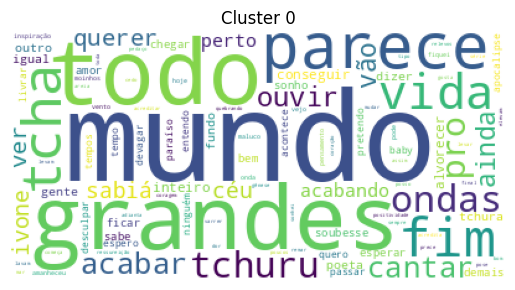

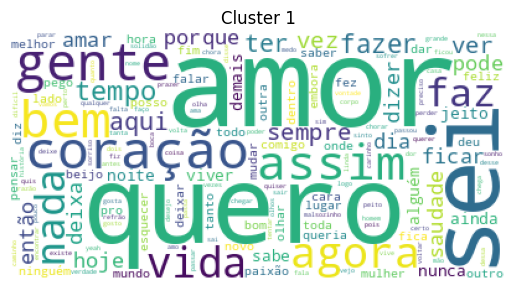

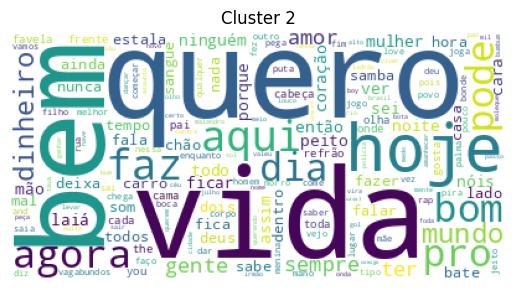

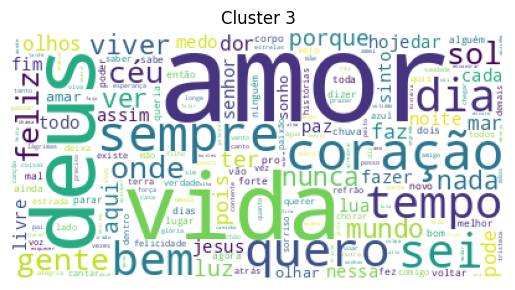

In [55]:
generate_word_clouds(counting_words(letras,labels_w2v, 'w2v_group'))

## Perguntas sobre o Word2Vec
Responda cada perguntando apresentando uma justificativa

1. Considerando os artistas de cada grupo, é possível verificar alguma conexão entre eles? (Ex: gênero, estilo de música, temas abordados)

Sim, o Word2Vec agrupa as músicas com base no contexto em que as palavras são usadas. Músicas com temas similares, como "amor", "festa" ou "política", terão vetores de palavras parecidos, e a média desses vetores (que representa a música) as colocará próximas umas das outras. Mas em relação ao genero musical não é tão parecido.

2. Considerando as nuvens de palavras de cada grupo, argumente se existe um grupo bem definido ou se não existe uma definição clara sobre que tipo de música (tema) cada grupo tem.

Os grupos de palavras tendem a ter uma definição muito clara e coerente porque vai além da simples co-ocorrência e cria vetores que capturam o significado e as relações semânticas entre as palavras. Cria um conjunto de palavras que têm um significado comum. As "nuvens" de palavras de cada grupo são muito coesas e representar um tema óbvio (por exemplo, "romance", "festa", "religiosidade"), tornando a definição de cada grupo muito mais nítida.

3. De maneira geral, você acha que os resultados com o Word2Vec são mais consistentes que os dos métodos anteriores?

Sim porque consistência se refere à capacidade do método de agrupar itens de maneira semanticamente lógica.

  O TF-IDF se baseia na frequência das palavras, o que pode agrupar músicas com base em vocabulários raros, mas não necessariamente em temas.

  O PPMI melhora ao focar na co-ocorrência, mas ainda tem um limite.

  O Word2Vec, aprende a representação vetorial de cada palavra a partir de um contexto de palavras vizinhas. Isso permite que ele compreenda que palavras como "carro" e "automóvel" são sinônimos. Essa compreensão mais "profunda" faz com que os agrupamentos de músicas sejam os mais tematicamente coerentes.

A única coisa que destoa um pouco dos resultados é em relação ao gênero, pois todos não tem relação, como por exemplo com o teste em algumas palavras tem músicas de Rock, Pop, Samba, Hip-Hop...